# A3TGCN


In [1]:
import torch
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from torch_geometric_temporal.signal import temporal_signal_split, StaticGraphTemporalSignal 
from torch_geometric_temporal.nn.recurrent import A3TGCN, TGCN


In [2]:

def populate_node_target_features(ticker: str, node_grp: h5py.Group, target_grp: h5py.Group, n_periods: int) -> None:
    # Get the data from the API 
    # Data dimension is [num_months, num_features] per company

    # Get all the quarterly data from the API for the company
    api_functions = ['TIME_SERIES_MONTHLY']
    data = dict()
    for api_function in api_functions:
    
        url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
        try:
            r = requests.get(url)
            data[api_function] = r.json()
            # pause 1 seconds between requests to avoid hitting the API request limit
            time.sleep(0.5)
            
        except:
            print(f'Error retrieving {api_function} data from API for ')
            return
    
    
    # Stack the sequence data into a matrix
    node_matrix = np.zeros((n_periods, n_features))
    target_matrix = np.zeros((n_periods, 1))
    # create date string for ending date of date, november 15th of the 2023
    start_date = dt.datetime(2023, 11, 15)    
    
    # Time series features
    monthly_price = data['TIME_SERIES_MONTHLY']['Monthly Time Series']
    for qidx in range(n_periods):        

        features = []        
        monthly_price_features = [            
            '4. close',
            '5. volume',
        ]
        # So the first month here is October 2023
        ref_date = start_date - dt.timedelta(days=(30 * (qidx+1)))
        date_str = f'{ref_date.year}-{ref_date.month:02d}'
        # find the date in the monthly price keys that matches the first 7 chars of date_str
        date_key = [key for key in monthly_price.keys() if key[:7] == date_str][0]

        features.extend([monthly_price[date_key][feature] for feature in monthly_price_features])
        
        features.append(ref_date.month)
        features.append(ref_date.year)
        
       
        # Convert any 'none' strings in the features list to None
        features = [None if feature == 'None' else feature for feature in features]        
        features = np.array(features, dtype=np.float32)
        
        # Store the features in the hdf5 file, and put the data in order of increasing date
        node_matrix[n_periods-1-qidx, :] = features
        target_matrix[n_periods-1-qidx, :] = np.array(monthly_price[date_key]['2. high'], dtype=np.float32)
    node_grp[ticker] = node_matrix
    target_grp[ticker] = target_matrix
    

In [3]:

def populate_edge_features(pair: str, edge_grp: h5py.Group) -> None:
    # Get the data from the API
    # Data dimension is [1], one edge weight for each pair of companies

    # Get the company overview data for each of the companies in the pair
    (ticker1, ticker2) = pair.split('_')
    api_functions = ['OVERVIEW']
    data = dict()
    for ticker in (ticker1, ticker2):
        for api_function in api_functions:
            url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
            try:
                r = requests.get(url)
                data[ticker] = r.json()
                time.sleep(0.5)
            except:
                print(f'Error retrieving {api_function} data from API')
                return
            
    # Get the features we want from the company overview data
    feature1 = []
    feature2 = []
    # Ticker 1 features
    feature1.extend([data[ticker1]['Sector'], data[ticker1]['Industry']])
    # Ticker 2 features
    feature2.extend([data[ticker2]['Sector'], data[ticker2]['Industry']])

    # create a feature string from each of the features
    feature1_str = ' '.join(feature1)
    feature2_str = ' '.join(feature2)

    # Use the sentence transformer to get the embeddings for the features
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')
    feature1_embedding = model.encode(feature1_str)
    feature2_embedding = model.encode(feature2_str)
    # Convert the embeddings to a column vector
    feature1_embedding = feature1_embedding.reshape(1, -1)
    feature2_embedding = feature2_embedding.reshape(1, -1)    
    
    # Compute the cosine similarity between the embeddings
    edge_weight = cosine_similarity(feature1_embedding, feature2_embedding)

    # Store the edge weight in the hdf5 file
    edge_grp[pair] = edge_weight



In [4]:

def store_ATGCN_data(data_path: str, company_symbols: list, reprocess_features: bool) -> None:
    
    def process_nodes():
        # For each company check if it's new because we might add new companies to the list of companies we want to include in our GNN
        nbar = tqdm(company_symbols)
        for ticker in nbar:
            nbar.set_description(f'Processing {ticker} node features')
            if ticker not in node_grp.keys():
                
                populate_node_target_features(ticker, node_grp, target_grp, n_periods)
                

    def process_edges():
        # Iterate through all unique pairs of companies and create a dataset for each pair if it doesn't exist to define the edge features
        # because there might be new ones in case they were added to the list of companies we want to include in our GNN
        ebar = tqdm(range(len(company_symbols)))
        for i in ebar:
            ebar.set_description(f'Processing {company_symbols[i]} edge features')
            for j in range(i+1, len(company_symbols)):
                pair = company_symbols[i] + '_' + company_symbols[j]
                if pair not in edge_grp.keys():
                    # If the edge pair is new, then compute the edge weight and create a hdf5 dataset to store it
                    
                    populate_edge_features(pair, edge_grp)
                   
    
    # Two main cases here: 1) We want to reprocess all the features, or 2) Features are the same but we added new companies to GNN
    if os.path.exists(data_path) and reprocess_features:
        print('Deleting old data and reprocessing features')
        # Opening the file in write mode deletes all the data
        ATGCN_data = h5py.File(data_path, 'w')

        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        node_grp = ATGCN_data.create_group('nodes')
        edge_grp = ATGCN_data.create_group('edges')
        target_grp = ATGCN_data.create_group('targets')
       
        process_nodes()

        process_edges()        


    else:
        # Opening the file in append mode allows us to add new data without deleting the old data or create a new file if it doesn't exist
        print('Appending new data to existing file or creating new file if it does not exist')
        ATGCN_data = h5py.File(data_path, 'a')
        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        if 'nodes' not in ATGCN_data.keys():
            node_grp = ATGCN_data.create_group('nodes')
        if 'edges' not in ATGCN_data.keys():
            edge_grp = ATGCN_data.create_group('edges')
        if 'targets' not in ATGCN_data.keys():
            target_grp = ATGCN_data.create_group('targets')
        node_grp = ATGCN_data['/nodes']
        edge_grp = ATGCN_data['/edges']
        target_grp = ATGCN_data['/targets']
        
        process_nodes()
               
        process_edges()

        
    #close the hdf5 file
    ATGCN_data.close()
    
    
        

## Define parameters for the model

In [5]:
# Specify the companies we want to include in our GNN
#dow_list = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'DIS']

# Gather and save the data we want to collect for each company so we don't have to do a lot of requests to the API
company_symbols = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
company_symbols = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO']
# Alpha Vantage API key
api_key = 'IMSWKZZ2ILUS0FKX'
# Look for the data in the data folder
ATGCN_data_path = 'data/A3TGCN_PriceData_12months_20231126.hdf5'
# Specify the number of features we want to collect for each company
n_features = 4
# There will be multiple quarters of data for this graph, so we need to specify the number of quarters we want to include
n_periods = 24
# Parameter that determines if companies are similar enough to be connected by an edge
edge_similarity_threshold = 0.0




# Get the ATGCN data
#store_ATGCN_data(data_path=ATGCN_data_path, company_symbols=company_symbols, reprocess_features=False)

Appending new data to existing file or creating new file if it does not exist


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Generate training data from data file

In [21]:
## This Cell: Retreive the ATGCN data, organize it into a PyTorch Geometric Data object for train, val and test and then return the Data objects

# Open the hdf5 file for reading
ATGCN_data = h5py.File(ATGCN_data_path, 'r')
company_symbols = list(ATGCN_data['nodes'].keys())

node_grp = ATGCN_data['/nodes']
edge_grp = ATGCN_data['/edges']
target_grp = ATGCN_data['/targets']





#### Build the PyTorch Geometric Data object for the training data ####

## NODES and TARGETS ##
# Build the nodes, the newest quarters are at the beginning of the matrix so the qtr index counts backwards

def get_node_data(n_periods):
    nodes = []
    targets = []
    for ticker in company_symbols:
        # Get the node features for the company
        nodes.append(node_grp[ticker][:n_periods, :])
        # Compute the score for the next quarter as ground truth for training        
        targets.append(target_grp[ticker])
    nodes = np.array(nodes, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    # swap the first and second node dimensions to get the right shape for PyTorch Geometric
    return torch.tensor(nodes.swapaxes(1,2)), torch.tensor(targets.swapaxes(1,2).squeeze())

## EDGES ##
# For each period, there are edges between companies that are similar enough to be connected

def get_edge_data():
    # We need to define all the pairwise directed edges if the edge weight is above the similarity threshold
    edges = []
    edge_wts = []
    for cidx, ticker in enumerate(company_symbols):
        # edges can be out of order in the hdf5 file so we need to check both directions
        for eidx in range(len(company_symbols)):
            pair = ticker + '_' + company_symbols[eidx]
            if pair in edge_grp.keys():
                if edge_grp[pair][0] > edge_similarity_threshold:
                    edges.append([cidx, eidx])
                    edge_wts.append(edge_grp[pair][0])
            # The ordering of the edge labels is unpredictable so we need to check both directions
            pair = company_symbols[eidx] + '_' + ticker
            if pair in edge_grp.keys():
                if edge_grp[pair][0] > edge_similarity_threshold:
                    edges.append([cidx, eidx])
                    edge_wts.append(edge_grp[pair][0])
    edges = torch.tensor(np.array(edges, dtype=np.int64).T)
    edge_wts = torch.tensor(np.array(edge_wts, dtype=np.float32))
    return edges, edge_wts

## Train data ##
# Normalize the node features

scaler = StandardScaler()

#normalize node data
nodes, targets = get_node_data(n_periods)
scaler.fit(nodes.swapaxes(1,2).reshape(-1, nodes.shape[1]))

# apply the scaler normalization to the nodes and targets
nodes_tmp = nodes.swapaxes(1,2).reshape(-1, nodes.shape[1])
norm_nodes = scaler.transform(nodes_tmp)
norm_nodes = norm_nodes.reshape(nodes.shape[0], nodes.shape[2], nodes.shape[1]).swapaxes(1,2)
norm_nodes = torch.tensor(norm_nodes, dtype=torch.float32)

targets_tmp = targets.reshape(-1)
norm_targets = (targets_tmp - scaler.mean_[0]) / scaler.scale_[0]
norm_targets = norm_targets.reshape(targets.shape[0], targets.shape[1])

# Split the data into train, val and test
n_train_periods = 16
n_val_periods = 6
n_test_periods = 1

# defind the train, val and test data sets, but we don't want the last period because we don't have a target for it
norm_nodes_train = norm_nodes[:, :, :n_train_periods]
norm_targets_train = norm_targets[:, 1:n_train_periods+1]
norm_nodes_val = norm_nodes[:, :, n_train_periods:n_train_periods+n_val_periods]
norm_targets_val = norm_targets[:, n_train_periods+1:n_train_periods+n_val_periods+1]
norm_nodes_test = norm_nodes[:, :, n_train_periods+n_val_periods:-1]
norm_targets_test = norm_targets[:, n_train_periods+n_val_periods+1:]

edges, edge_wts = get_edge_data()


# Now we can close the data file
ATGCN_data.close()


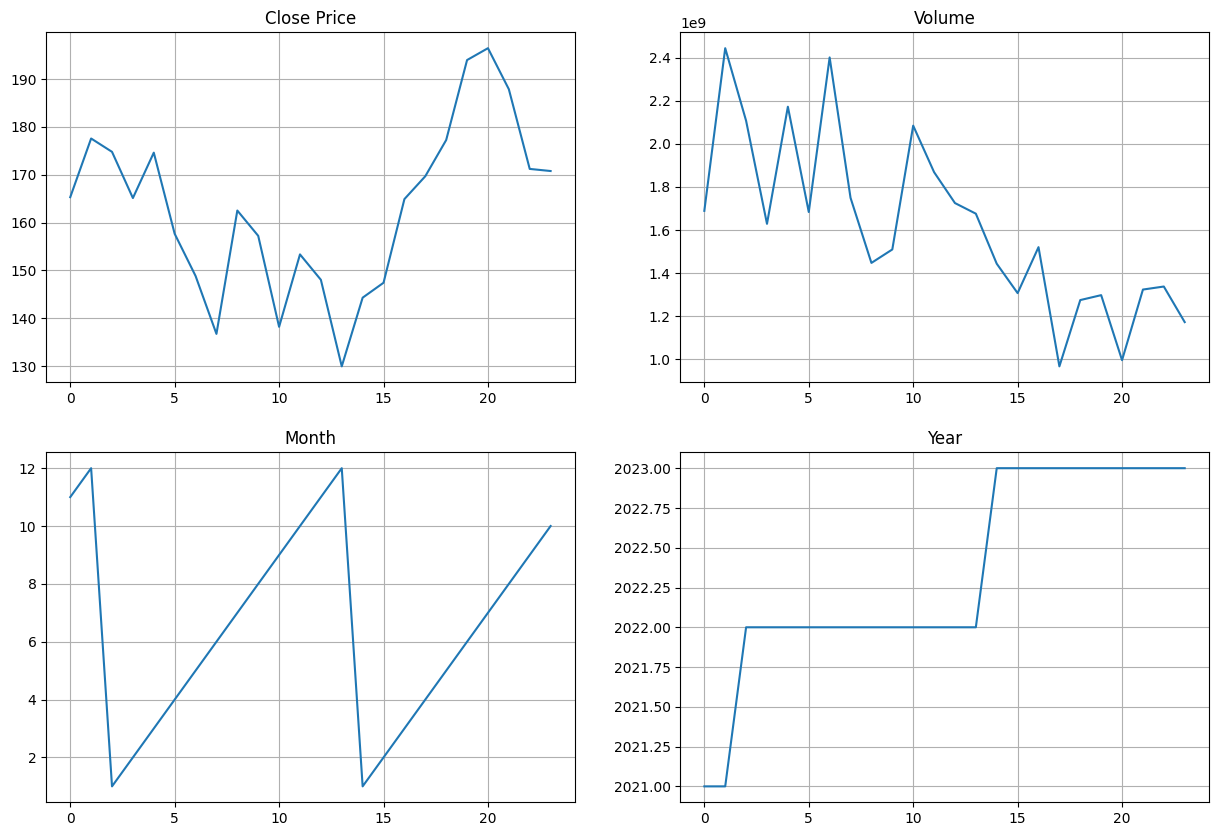

In [23]:
# Plot the data for the first company (AAPL) in the node data as subplots and add grid lines
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(nodes[0, 0, :])
axs[0, 0].set_title('Close Price')
axs[0, 0].grid(True)
axs[0, 1].plot(nodes[0, 1, :])
axs[0, 1].set_title('Volume')
axs[0, 1].grid(True)
axs[1, 0].plot(nodes[0, 2, :])
axs[1, 0].set_title('Month')
axs[1, 0].grid(True)
axs[1, 1].plot(nodes[0, 3, :])
axs[1, 1].set_title('Year')
axs[1, 1].grid(True)
plt.show()





## Training the GNN

In [36]:
import torch.nn.functional as F

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features):
        super(TemporalGNN, self).__init__()
        self.recurrent = TGCN(in_channels=node_features, 
                              out_channels=96,
                              add_self_loops=False)
        self.linear = torch.nn.Linear(96, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = F.dropout(y, training=self.training, p=0.1)
        y = self.linear(y)
        return y, h

In [42]:
#device = torch.device('cpu') # cuda
model = TemporalGNN(node_features=4).cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# add an exponential learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99, verbose=False)
# Create SME loss function
loss_fn = torch.nn.MSELoss()

In [43]:

# Create model and optimizers
norm_nodes_train.cpu()
norm_targets.cpu()
edges.cpu()


total_train_loss = []
total_val_loss = []
print("Running training...")

for epoch in tqdm(range(225)): 
    train_loss = 0
    train_hidden_state = None
    model.train()
    for step in range(norm_targets_train.shape[1]): 
        snapshot = norm_nodes_train[:,:,step:step+1]
        x = snapshot.squeeze()
        # Get model predictions
        y_hat, train_hidden_state = model(x=x, edge_index=edges, edge_weight=edge_wts, prev_hidden_state=train_hidden_state)
        #print(y_hat)
        # Mean squared error
        target = norm_targets_train[:,step:step+1]
        train_loss = train_loss + torch.mean((y_hat - target)**2)
      
    train_loss = train_loss / (step+1)    
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    total_train_loss.append(train_loss.item())
    y_hat_train = y_hat

    val_hidden_state = train_hidden_state

    # Compute validation loss
    val_loss = 0
    model.eval()
    # Store for analysis
    for step in range(norm_targets_val.shape[1]): 
        snapshot = norm_nodes_val[:,:,step:step+1]
        x = snapshot.squeeze()
        # Get model predictions
        y_hat, val_hidden_state = model(x=x, edge_index=edges, edge_weight=edge_wts, prev_hidden_state=val_hidden_state)
        #print(y_hat)
        # Mean squared error
        target = norm_targets_val[:,step:step+1]
        val_loss = val_loss + torch.mean((y_hat - target)**2)
        
    val_loss = val_loss / (step+1)
    total_val_loss.append(val_loss.item())
    y_hat_val = y_hat
    



print(f"Epoch {epoch} train MSE loss: {train_loss.item():.4f}")
print(f"{y_hat_train.T}|{norm_targets_train[:,step:step+1].T}")
print(f"Epoch {epoch} val MSE loss: {val_loss.item():.4f}")
print(f"{y_hat_val.T}|{norm_targets_val[:,step:step+1].T}")


Running training...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 224 train MSE loss: 0.0551
tensor([[ 0.0366,  1.2065,  0.2875,  0.5194,  1.2832,  0.3040, -1.9521]],
       grad_fn=<PermuteBackward0>)|tensor([[-0.1197,  1.3455,  0.0689, -0.2568,  0.7972,  0.1950, -1.9731]])
Epoch 224 val MSE loss: 0.1370
tensor([[ 0.2827,  0.5996,  0.0474,  0.3405,  1.1716,  0.5233, -2.2758]],
       grad_fn=<PermuteBackward0>)|tensor([[ 0.2596,  1.6094, -0.1544,  0.8447,  1.8644,  0.8543, -1.8677]])


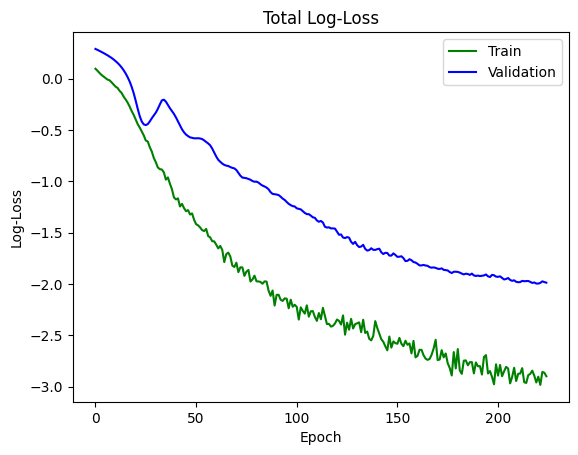

In [44]:
# plot the total loss
plt.plot(np.log(total_train_loss), 'g', label='Train')
plt.plot(np.log(total_val_loss), 'b', label='Validation')
plt.legend(loc='upper right')
plt.title('Total Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Log-Loss')
plt.xticks(np.arange(0, len(total_train_loss), 50))
plt.show()


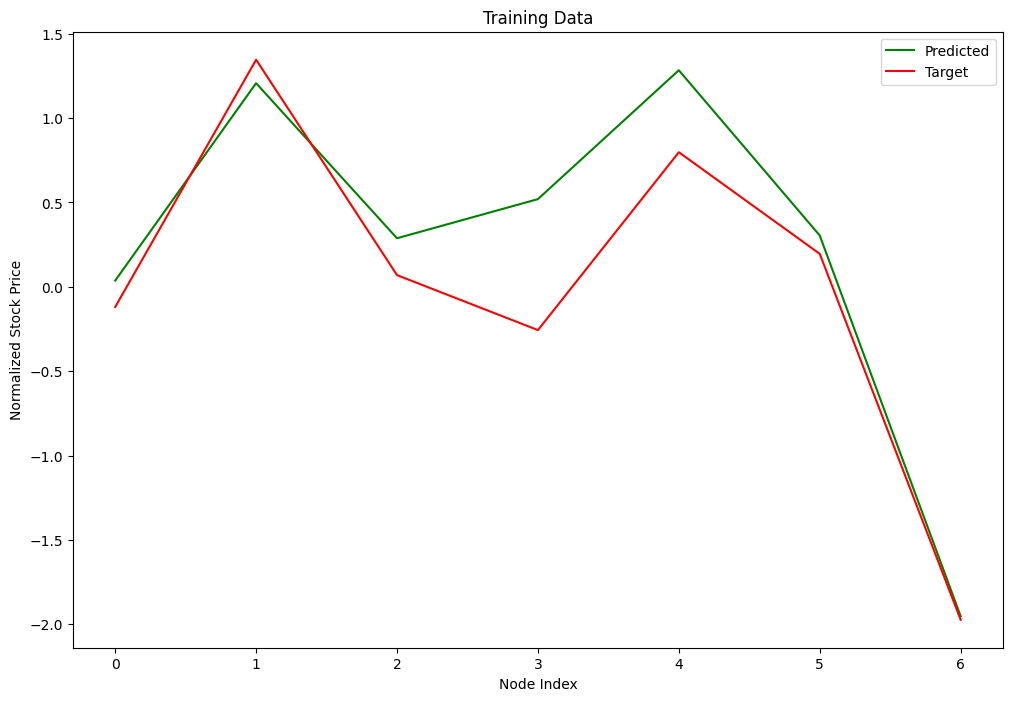

In [45]:
# Plot the node estimates vs the targets
plt.figure(figsize=(12, 8))
plt.plot(y_hat_train.detach().numpy(), 'g', label='Predicted')
plt.plot(norm_targets_train[:,step:step+1].detach().numpy(), 'r', label='Target')
plt.legend()
plt.ylabel('Normalized Stock Price')
plt.xlabel('Node Index')
plt.title('Training Data')
plt.show()

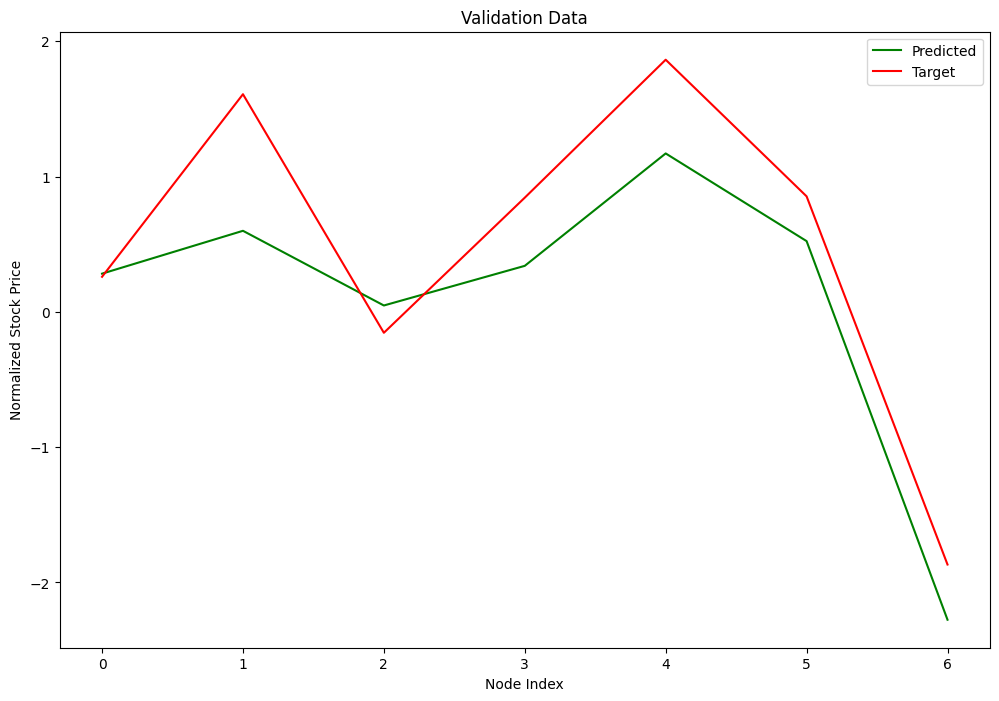

In [46]:
# Plot the node estimates vs the targets
plt.figure(figsize=(12, 8))
plt.plot(y_hat_val.detach().numpy(), 'g', label='Predicted')
plt.plot(norm_targets_val[:,step:step+1].detach().numpy(), 'r', label='Target')
plt.legend()
plt.ylabel('Normalized Stock Price')
plt.xlabel('Node Index')
plt.title('Validation Data')
plt.show()

In [ ]:
val_hidden_state = train_hidden_state

loss = 0
model.eval()
# Store for analysis
for step in range(norm_targets_val.shape[1]): 
    snapshot = norm_nodes[:,:,step:step+1]
    x = snapshot.squeeze()
    # Get model predictions
    y_hat, val_hidden_state = model(x=x, edge_index=edges, edge_weight=edge_wts, prev_hidden_state=val_hidden_state)
    #print(y_hat)
    # Mean squared error
    target = norm_targets[:,step+1:step+2]
    loss = loss + torch.mean((y_hat - target)**2)
      
loss = loss / (step+1)    
print(f"Val MSE Loss: {loss.item():.4f}")
print(f"{y_hat.T}|{norm_targets[:,step+1:step+2].T}")